## Temperature Stabilized Measurements - 10°C, 20°C, 30°C, 1 g/L Starch

### Loading the Libraries

In [91]:
import os
#import earthpy as et
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy as sp
import statsmodels.formula.api as smf

import matplotlib.colors as col


import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
import pandas
from sklearn import tree
#import pydotplus
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
#pd.options.plotting.backend = "matplotlib" #Abändern des Plot Backends
pd.options.plotting.backend = "plotly"
#pd.options.mode.use_inf_as_na = True

In [92]:
import sys

if sys.platform.startswith('linux'):
    # Linux specific procedures
    path = 'technology/experiments/sonicMeasure/data/RunsTControlled/'
    df_10 = pd.read_csv(path + "sonicMeasureRunData10starch1gL.csv", sep=",")
    df_20 = pd.read_csv(path + "sonicMeasureRunData20_starch1gL.csv", sep=",")
    df_30 = pd.read_csv(path + "sonicMeasureRunData30_starch1gL.csv", sep=",")
    pass
elif sys.platform.startswith('darwin'):
    # MacOs specific procedures
    df_10 = pd.read_csv(r"/Volumes/Data/usePAT/technology/experiments/sonicMeasure/data/RunsTControlled/sonicMeasureRunData10starch1gL.csv", sep=",")
    df_20 = pd.read_csv(r"/Volumes/Data/usePAT/technology/experiments/sonicMeasure/data/RunsTControlled/sonicMeasureRunData20_starch1gL.csv", sep=",")
    df_30 = pd.read_csv(r"/Volumes/Data/usePAT/technology/experiments/sonicMeasure/data/RunsTControlled/sonicMeasureRunData30_starch1gL.csv", sep=",")

elif sys.platform.startswith('win32'):
    # Windows specific procedures
    df_10 = pd.read_csv(r"C:\Users\Stefan\Documents\usePAT\technology\experiments\sonicMeasure\data\RunsTControlled\sonicMeasureRunData10starch1gL.csv", sep=",")
    df_20 = pd.read_csv(r"C:\Users\Stefan\Documents\usePAT\technology\experiments\sonicMeasure\data\RunsTControlled\sonicMeasureRunData20_starch1gL.csv", sep=",")
    df_30 = pd.read_csv(r"C:\Users\Stefan\Documents\usePAT\technology\experiments\sonicMeasure\data\RunsTControlled\sonicMeasureRunData30_starch1gL.csv", sep=",")

In [93]:
os.getcwd()

'/home/jupyter-stefan.tauber'

### About the Data

Features:
- timestamp: Datetimeobject
- Urms: Outputvoltage in FSV
- Irms: Outputcurrent in FSV
- phase: Phase between Urms nad Irms in FSV
- frequency: in kHz
- on-status: 0...US is off, 1...US is on
- temperature: temperature of the reactorvessel in °C
- concentration of particles (starch) in g/L
- dTime: elapsed time in sec from the last measurement; value of first instance is mean of column

In [94]:
df_10['timestamp'] = pd.to_datetime(df_10['timestamp'])
df_10_status = df_10['on-status']
df_10_status = df_10_status.map({'off': 0, 'on':1})
df_10['on-status'] = df_10_status

#make another dataset for classification of temp
df_10_c = df_10.copy()
df_10_c = df_10_c.loc[df_10_c.temperature <10.3] #get rid of data in range of unstable temp at beginning
df_10_c = df_10_c.reset_index()
del df_10_c['index']
del df_10_c['temperature']
df_10_c.insert(6,'temperature', 10)
df_10['delta_t'] =  df_10['timestamp'] - df_10['timestamp'].shift()
df_10['dTime'] = df_10['delta_t'].dt.total_seconds() #deltaT as column
del df_10['delta_t']
df_10.fillna(df_10.mean(), inplace=True) #fill all NaN with mean of column
#apply the same things to the calssification df
df_10_c['delta_t'] =  df_10_c['timestamp'] - df_10_c['timestamp'].shift()
df_10_c['dTime'] = df_10_c['delta_t'].dt.total_seconds() #deltaT as column
del df_10_c['delta_t']
df_10_c.fillna(df_10_c.mean(), inplace=True) #fill all NaN with mean of column
df_10

,timestamp,Urms,Irms,phase,frequency,on-status,temperature,dTime
0,2021-06-24 12:42:50.326582,2823.0,2879.0,7414.0,2007,0,19.95,7.069541
1,2021-06-24 12:42:57.349882,2824.0,2880.0,7415.0,2007,0,19.96,7.023300
2,2021-06-24 12:43:04.708584,2824.0,2880.0,7416.0,2007,0,19.95,7.358702
3,2021-06-24 12:43:11.747217,2824.0,2880.0,7416.0,2007,0,19.93,7.038633
4,2021-06-24 12:43:18.785923,2824.0,2880.0,7415.0,2007,0,19.93,7.038706
...,...,...,...,...,...,...,...,...
655,2021-06-24 14:00:00.917445,24778.0,4975.0,8341.0,2207,1,10.07,7.149624
656,2021-06-24 14:00:07.941670,24782.0,4969.0,8351.0,2207,1,10.06,7.024225
657,2021-06-24 14:00:14.980324,24784.0,4970.0,8356.0,2207,1,10.07,7.038654
658,2021-06-24 14:00:22.002955,24785.0,4970.0,8362.0,2207,1,10.03,7.022631


In [95]:
df_20['timestamp'] = pd.to_datetime(df_20['timestamp'])
df_20_status = df_20['on-status']
df_20_status = df_20_status.map({'off': 0, 'on':1})
df_20['on-status'] = df_20_status

#make another dataset for classification of temp
df_20_c = df_20.copy()
df_20_c = df_20_c.loc[df_20_c.temperature <20.3] #get rid of data in range of unstable temp at beginning
df_20_c = df_20_c.reset_index()
del df_20_c['index']
del df_20_c['temperature']
df_20_c.insert(6,'temperature', 20)
df_20['delta_t'] =  df_20['timestamp'] - df_20['timestamp'].shift()
df_20['dTime'] = df_20['delta_t'].dt.total_seconds() #deltaT as column
del df_20['delta_t']
df_20.fillna(df_20.mean(), inplace=True) #fill all NaN with mean of column
#apply the same things to the calssification df
df_20_c['delta_t'] =  df_20_c['timestamp'] - df_20_c['timestamp'].shift()
df_20_c['dTime'] = df_20_c['delta_t'].dt.total_seconds() #deltaT as column
del df_20_c['delta_t']
df_20_c.fillna(df_20_c.mean(), inplace=True) #fill all NaN with mean of column
df_20

,timestamp,Urms,Irms,phase,frequency,on-status,temperature,dTime
0,2021-06-24 11:24:58.322277,2823.0,2879.0,7418.0,2007,0,29.95,7.077010
1,2021-06-24 11:25:05.345311,2823.0,2879.0,7417.0,2007,0,29.94,7.023034
2,2021-06-24 11:25:12.719921,2823.0,2879.0,7418.0,2007,0,29.95,7.374610
3,2021-06-24 11:25:19.758218,2823.0,2879.0,7415.0,2007,0,29.94,7.038297
4,2021-06-24 11:25:26.781609,2823.0,2879.0,7424.0,2007,0,29.94,7.023391
...,...,...,...,...,...,...,...,...
655,2021-06-24 12:42:13.821745,24748.0,4512.0,8988.0,2207,1,19.95,7.134835
656,2021-06-24 12:42:20.860517,24755.0,4511.0,8999.0,2207,1,19.95,7.038772
657,2021-06-24 12:42:27.883245,24759.0,4513.0,9012.0,2207,1,19.94,7.022728
658,2021-06-24 12:42:35.033876,24759.0,4514.0,9018.0,2207,1,19.95,7.150631


In [96]:
df_30['timestamp'] = pd.to_datetime(df_30['timestamp'])
df_30_status = df_30['on-status']
df_30_status = df_30_status.map({'off': 0, 'on':1})
df_30['on-status'] = df_30_status

#make another dataset for classification of temp
df_30_c = df_30.copy()
df_30_c = df_30_c.loc[df_30_c.temperature <30.3] #get rid of data in range of unstable temp at beginning
df_30_c = df_30_c.reset_index()
del df_30_c['index']
del df_30_c['temperature']
df_30_c.insert(6,'temperature', 30)
df_30['delta_t'] =  df_30['timestamp'] - df_30['timestamp'].shift()
df_30['dTime'] = df_30['delta_t'].dt.total_seconds() #deltaT as column
del df_30['delta_t']
df_30.fillna(df_30.mean(), inplace=True) #fill all NaN with mean of column
#apply the same things to the calssification df
df_30_c['delta_t'] =  df_30_c['timestamp'] - df_30_c['timestamp'].shift()
df_30_c['dTime'] = df_30_c['delta_t'].dt.total_seconds() #deltaT as column
del df_30_c['delta_t']
df_30_c.fillna(df_30_c.mean(), inplace=True) #fill all NaN with mean of column
df_30

,timestamp,Urms,Irms,phase,frequency,on-status,temperature,dTime
0,2021-06-24 10:06:25.569075,2830.0,2893.0,7427.0,2007,0,30.02,7.160577
1,2021-06-24 10:06:32.592768,2830.0,2893.0,7421.0,2007,0,29.99,7.023693
2,2021-06-24 10:06:39.615364,2830.0,2893.0,7431.0,2007,0,30.01,7.022596
3,2021-06-24 10:06:46.766190,2830.0,2893.0,7431.0,2007,0,30.02,7.150826
4,2021-06-24 10:06:53.788723,2830.0,2893.0,7429.0,2007,0,30.02,7.022533
...,...,...,...,...,...,...,...,...
653,2021-06-24 11:24:21.832903,24604.0,5539.0,13173.0,2207,1,29.97,7.151001
654,2021-06-24 11:24:28.855615,24601.0,5198.0,13047.0,2207,1,29.98,7.022712
655,2021-06-24 11:24:35.894359,24668.0,4659.0,10691.0,2207,1,29.97,7.038744
656,2021-06-24 11:24:43.029318,24689.0,4826.0,10691.0,2207,1,29.96,7.134959


### Inspecting the data

In [97]:
df_10.describe()

,Urms,Irms,phase,frequency,on-status,temperature,dTime
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,12760.501515,6331.796970,9030.628788,2107.000000,0.454545,11.866348,7.069541
std,10897.016867,4173.747313,2023.838845,38.394012,0.498307,3.037984,0.055828
min,2822.000000,2875.000000,7401.000000,2007.000000,0.000000,10.030000,7.022034
25%,2823.000000,2878.000000,7412.000000,2102.000000,0.000000,10.100000,7.022928
50%,2824.000000,2879.500000,7418.000000,2107.000000,0.000000,10.160000,7.038735
75%,24802.000000,10529.250000,10526.750000,2112.000000,1.000000,12.527500,7.135461
max,25095.000000,17856.000000,14844.000000,2207.000000,1.000000,19.960000,7.358702


In [98]:
df_20.describe()

,Urms,Irms,phase,frequency,on-status,temperature,dTime
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,12512.428788,6997.234848,9835.874242,2107.000000,0.454545,21.454197,7.077010
std,10628.640931,5193.769375,2940.439004,38.394012,0.498307,2.832286,0.132486
min,2822.000000,2876.000000,7386.000000,2007.000000,0.000000,19.810000,7.020794
25%,2823.000000,2879.000000,7414.750000,2102.000000,0.000000,20.020000,7.023031
50%,2824.000000,2880.000000,7420.000000,2107.000000,0.000000,20.110000,7.038735
75%,23920.250000,11675.250000,13181.250000,2112.000000,1.000000,20.320000,7.135093
max,25092.000000,21178.000000,14867.000000,2207.000000,1.000000,29.950000,9.822245


In [99]:
df_30.describe()

,Urms,Irms,phase,frequency,on-status,temperature,dTime
count,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000
mean,12482.262918,8421.846505,9380.506079,2106.980243,0.452888,30.075395,7.160577
std,10632.512045,6996.021916,2339.269781,38.450243,0.498154,0.066148,0.990802
min,2822.000000,2875.000000,7407.000000,2007.000000,0.000000,29.920000,7.022100
25%,2824.000000,2882.000000,7420.000000,2102.000000,0.000000,30.030000,7.023054
50%,2828.000000,2888.000000,7425.500000,2107.000000,0.000000,30.080000,7.038769
75%,24259.750000,16289.000000,11338.000000,2112.000000,1.000000,30.120000,7.136141
max,25081.000000,22562.000000,14859.000000,2207.000000,1.000000,30.220000,23.995080


In [100]:
C10_features = ['Urms', 'Irms', 'phase', 'frequency', 'on-status','temperature']
C20_features = ['Urms', 'Irms', 'phase', 'frequency', 'on-status','temperature']
C30_features = ['Urms', 'Irms', 'phase', 'frequency', 'on-status','temperature']
features_PCA = ['Urms', 'Irms', 'phase', 'frequency']


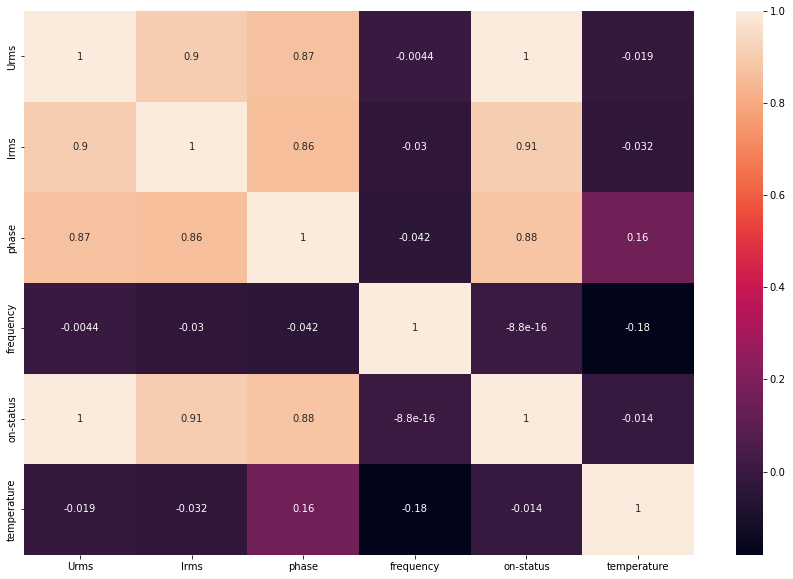

In [101]:
corr = df_10[C10_features].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values, annot = True)
plt.show()

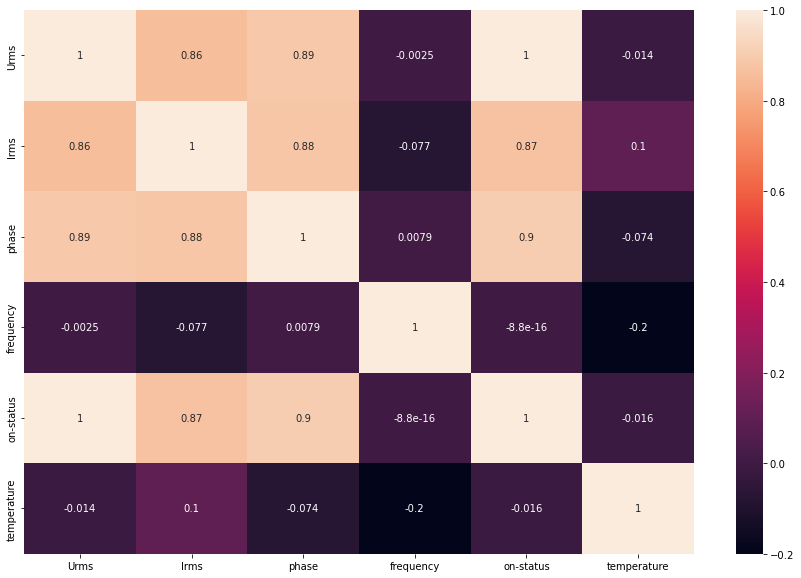

In [102]:
corr = df_20[C20_features].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values, annot = True)
plt.show()

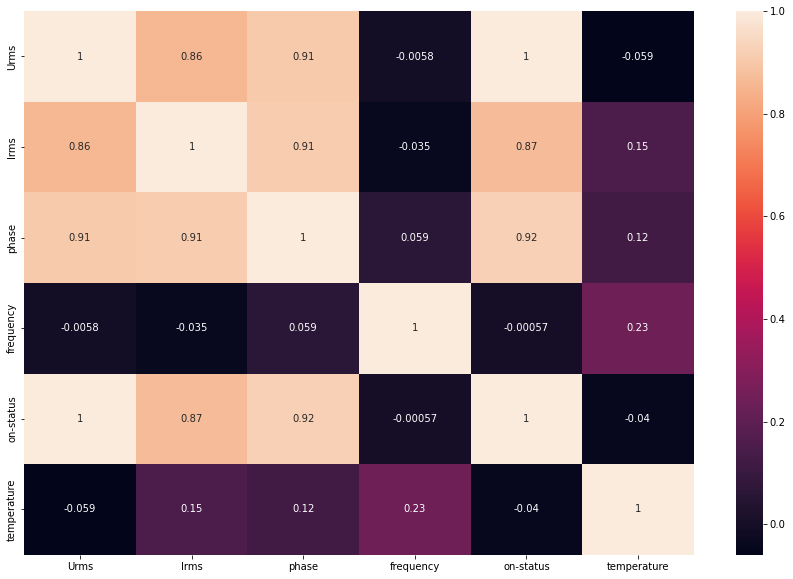

In [103]:
corr = df_30[C30_features].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values, annot = True)
plt.show()

As we want to include the concentration feature, we need to combine the datasets

### PCA

In order to include concentrations of particles we cobine the datasets to one single df.

In [104]:
df = df_10.append(df_20)
df = df.append(df_30)
df = df.rename(columns={'on-status' : 'on_status'})
df = df[df.on_status != 0]
df.reset_index(drop=True, inplace=True)
df

,timestamp,Urms,Irms,phase,frequency,on_status,temperature,dTime
0,2021-06-24 12:43:33.071445,24998.0,7365.0,9520.0,2007,1,19.91,7.150716
1,2021-06-24 12:43:40.094109,25003.0,7370.0,9523.0,2007,1,19.90,7.022664
2,2021-06-24 12:43:47.132930,25003.0,7373.0,9529.0,2007,1,19.89,7.038821
3,2021-06-24 12:43:54.155569,25004.0,7373.0,9531.0,2007,1,19.89,7.022639
4,2021-06-24 12:44:01.194345,25004.0,7375.0,9533.0,2007,1,19.85,7.038776
...,...,...,...,...,...,...,...,...
893,2021-06-24 11:24:21.832903,24604.0,5539.0,13173.0,2207,1,29.97,7.151001
894,2021-06-24 11:24:28.855615,24601.0,5198.0,13047.0,2207,1,29.98,7.022712
895,2021-06-24 11:24:35.894359,24668.0,4659.0,10691.0,2207,1,29.97,7.038744
896,2021-06-24 11:24:43.029318,24689.0,4826.0,10691.0,2207,1,29.96,7.134959


In [105]:
df_c = df_10_c.append(df_20_c)
df_c = df_c.append(df_30_c)
df_c = df_c.rename(columns={'on-status' : 'on_status'})
df_c = df_c[df_c.on_status != 0]
df_c.reset_index(drop=True, inplace=True)
df_c

,timestamp,Urms,Irms,phase,frequency,on_status,temperature,dTime
0,2021-06-24 13:09:28.251303,24817.0,10460.0,10944.0,2105,1,10,7.151008
1,2021-06-24 13:09:35.274066,24828.0,10141.0,11013.0,2105,1,10,7.022763
2,2021-06-24 13:09:42.312963,24863.0,10010.0,10792.0,2105,1,10,7.038897
3,2021-06-24 13:09:49.335614,24883.0,10048.0,10660.0,2105,1,10,7.022651
4,2021-06-24 13:09:56.486421,24902.0,10191.0,10529.0,2105,1,10,7.150807
...,...,...,...,...,...,...,...,...
716,2021-06-24 11:24:21.832903,24604.0,5539.0,13173.0,2207,1,30,7.151001
717,2021-06-24 11:24:28.855615,24601.0,5198.0,13047.0,2207,1,30,7.022712
718,2021-06-24 11:24:35.894359,24668.0,4659.0,10691.0,2207,1,30,7.038744
719,2021-06-24 11:24:43.029318,24689.0,4826.0,10691.0,2207,1,30,7.134959


In [106]:
from sklearn.preprocessing import StandardScaler
#Declaration of the features 

x_1 = df[features_PCA].copy()

# Define the scaler 
scaler_PCA = StandardScaler().fit(x_1)
# Scale the dataset
x_1 = pd.DataFrame(scaler_PCA.transform(x_1), columns=x_1.columns) #we need a df instead of an array for further processing
x_1

,Urms,Irms,phase,frequency
0,1.117401,-1.164133,-1.328720,-2.603381
1,1.125704,-1.163000,-1.326987,-2.603381
2,1.125704,-1.162320,-1.323522,-2.603381
3,1.127364,-1.162320,-1.322368,-2.603381
4,1.127364,-1.161867,-1.321213,-2.603381
...,...,...,...,...
893,0.463143,-1.577775,0.780783,2.604135
894,0.458161,-1.655022,0.708022,2.604135
895,0.569418,-1.777121,-0.652501,2.604135
896,0.604290,-1.739291,-0.652501,2.604135


In [107]:
#Declaration of the features 

x_1_c = df_c[features_PCA].copy()

# Define the scaler 
scaler_PCA = StandardScaler().fit(x_1_c)
# Scale the dataset
x_1_c = pd.DataFrame(scaler_PCA.transform(x_1_c), columns=x_1_c.columns) #we need a df instead of an array for further processing
x_1_c

,Urms,Irms,phase,frequency
0,0.821472,-0.520981,-0.460346,-0.078838
1,0.839523,-0.592577,-0.420120,-0.078838
2,0.896959,-0.621979,-0.548958,-0.078838
3,0.929780,-0.613450,-0.625911,-0.078838
4,0.960959,-0.581355,-0.702281,-0.078838
...,...,...,...,...
716,0.471933,-1.625452,0.839110,2.596693
717,0.467010,-1.701986,0.765655,2.596693
718,0.576959,-1.822959,-0.607839,2.596693
719,0.611421,-1.785478,-0.607839,2.596693


In [108]:
#Declaration of the temperature as target 
y_1 = df['temperature'].copy()
y_1_c = df_c['temperature'].copy()

y_1

0      19.91
1      19.90
2      19.89
3      19.89
4      19.85
       ...  
893    29.97
894    29.98
895    29.97
896    29.96
897    29.97
Name: temperature, Length: 898, dtype: float64

In [109]:
y_1_c

0      10
1      10
2      10
3      10
4      10
       ..
716    30
717    30
718    30
719    30
720    30
Name: temperature, Length: 721, dtype: int64

In [110]:
from sklearn.decomposition import PCA
n_components = 4
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x_1_c)
#principalDf = pd.DataFrame(data = principalComponents
#             , columns = ['principal component 1', 'principal component 2', 'principal component 3', ])
#principalDf
pca.get_covariance()

array([[ 1.00138889, -0.63711487, -0.78800851, -0.14075523],
       [-0.63711487,  1.00138889,  0.43212194, -0.15234725],
       [-0.78800851,  0.43212194,  1.00138889,  0.01539248],
       [-0.14075523, -0.15234725,  0.01539248,  1.00138889]])

In [111]:
explained_variance=pca.explained_variance_ratio_
explained_variance

array([0.56197362, 0.26716706, 0.13484145, 0.03601787])

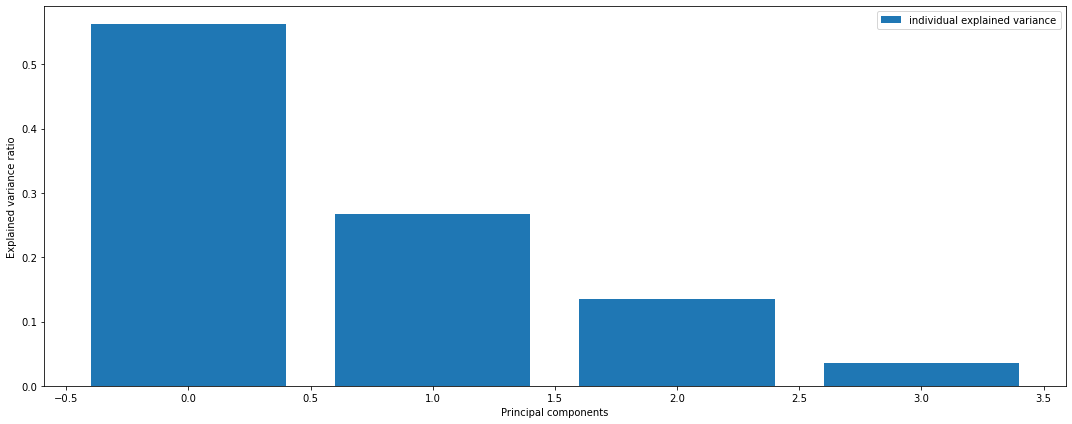

In [112]:
plt.figure(figsize=(15, 6))

plt.bar(range(n_components), explained_variance, alpha=1, align='center',
        label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [113]:
PCAcomp = pd.DataFrame(principalComponents)
PC_dict = {}
for idx,v in enumerate(PCAcomp):
    PC_dict[idx] = 'PC '+str(idx+1)
PCAcomp.rename(columns=PC_dict, inplace=True)
PCAcomp['temperature'] = y_1_c.values
PCAcomp

,PC 1,PC 2,PC 3,PC 4,temperature
0,-1.055035,-0.078860,0.081952,-0.195800,10
1,-1.080362,-0.058043,0.158518,-0.207325,10
2,-1.206181,-0.067560,0.098002,-0.172982,10
3,-1.266851,-0.080474,0.042742,-0.159927,10
4,-1.313917,-0.099829,-0.029410,-0.153691,10
...,...,...,...,...,...
716,-0.618474,2.910792,0.967499,-0.721428,30
717,-0.697494,2.927862,0.978760,-0.653493,30
718,-1.622273,2.844085,0.216218,0.031709,30
719,-1.624536,2.828412,0.186999,-0.006866,30


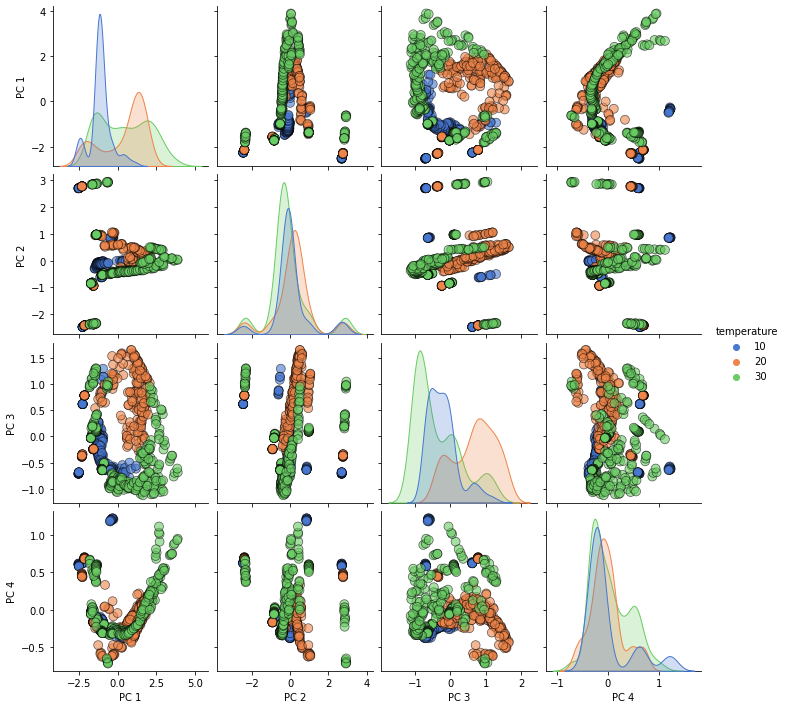

In [114]:
fig0 = sns.pairplot(PCAcomp, hue='temperature', palette = 'muted', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}) 
plt.show(fig0)

### Effect of features on the principle components

The components_ attribute provides principal axes in the feature space, representing the directions of maximum variance in the data. 

This means, we can see influence on each of the components by features. Reference: Ostwald Prasad


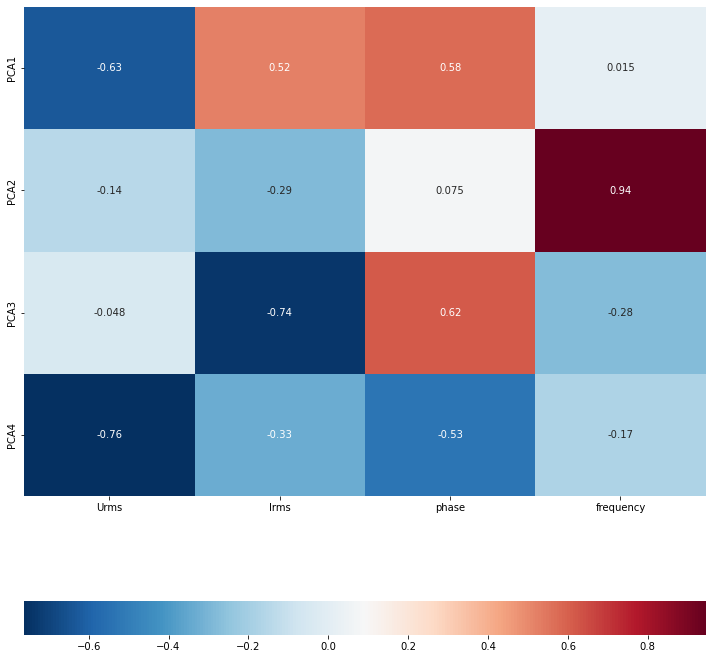

In [115]:
plt.figure(figsize=(10, 10))
sns.heatmap(pca.components_,
                 cmap='RdBu_r',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(x_1.columns),
                 annot= True,
                 cbar_kws={"orientation": "horizontal"})
plt.tight_layout()
plt.show()

This heatmap shows the main contributing features to the PCs. The distinct contributers to the first PC are XXX. . 
The second PC is interesting in the fact that it represents the interdependencies, by the laws of physics and the nature of biological fermentation, between residual sugar, density and alcohol. The third PC shows the interdependencies of acidity and the pH value of the wine.

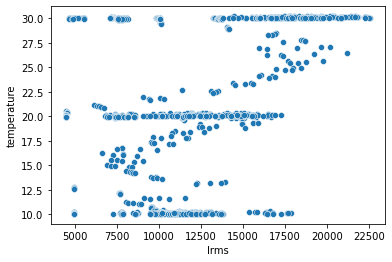

In [116]:
sns.scatterplot(data=df, x="Irms", y="temperature")
plt.show()

### Correlation combined DF

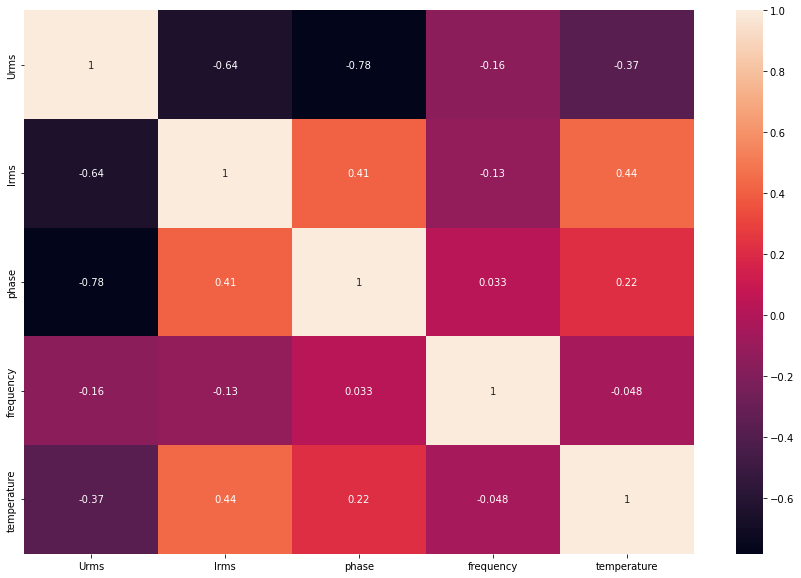

In [117]:
features = ['Urms', 'Irms', 'phase', 'frequency','temperature']
corr = df[features].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values, annot = True)
plt.show()

### Decision Tree Classifier

In [118]:
features_dt = ['Urms', 'Irms', 'phase', 'frequency']
x1_dt = df_c[features_dt].copy()
x1_dt

,Urms,Irms,phase,frequency
0,24817.0,10460.0,10944.0,2105
1,24828.0,10141.0,11013.0,2105
2,24863.0,10010.0,10792.0,2105
3,24883.0,10048.0,10660.0,2105
4,24902.0,10191.0,10529.0,2105
...,...,...,...,...
716,24604.0,5539.0,13173.0,2207
717,24601.0,5198.0,13047.0,2207
718,24668.0,4659.0,10691.0,2207
719,24689.0,4826.0,10691.0,2207


In [119]:
categories_str = ['10°C', '20°C', '30°C']
categories = {10 : '10°C', 20 : '20°C', 30 : '30°C'}
y_1_cat = y_1_c.replace(categories)
y_1_cat

0      10°C
1      10°C
2      10°C
3      10°C
4      10°C
       ... 
716    30°C
717    30°C
718    30°C
719    30°C
720    30°C
Name: temperature, Length: 721, dtype: object

In [120]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(x1_dt, y_1_cat):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt+=1
    
# Note that: 
# cross_val_score() parameter 'cv' will by default use StratifiedKFold spliting strategy if we just specify value of number of folds. 
# So you can bypass above step and just specify cv= 5 in cross_val_score() function

Fold:1, Train set: 648, Test set:73
Fold:2, Train set: 649, Test set:72
Fold:3, Train set: 649, Test set:72
Fold:4, Train set: 649, Test set:72
Fold:5, Train set: 649, Test set:72
Fold:6, Train set: 649, Test set:72
Fold:7, Train set: 649, Test set:72
Fold:8, Train set: 649, Test set:72
Fold:9, Train set: 649, Test set:72
Fold:10, Train set: 649, Test set:72


In [121]:
score = cross_val_score(tree.DecisionTreeClassifier(random_state= 42), x1_dt, y_1_cat, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [1.         1.         1.         1.         0.97222222 0.97222222
 0.94444444 0.98611111 0.97222222 0.97222222]
Average score: 0.98


The crossvalidation shows that the dataset is very homogeneous, without notable outliers. If there were notable outlieres the different splits of train and test data would result in vastly differing accuracy scores, depending on whether the outlier would be included in the training or test data. Now we will test for the optimal Tree depth:

In [122]:
max_depth = [1,2,3,4,5,6,7,8,9,10,11,12]

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeClassifier(max_depth= val, random_state= 42), x1_dt, y_1_cat, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(1): 0.521
Average score(2): 0.713
Average score(3): 0.778
Average score(4): 0.842
Average score(5): 0.893
Average score(6): 0.940
Average score(7): 0.968
Average score(8): 0.975
Average score(9): 0.979
Average score(10): 0.982
Average score(11): 0.982
Average score(12): 0.982


A tree depth of 6 is a good balance between depth and accuracy of prediction.

In [123]:
x_train,x_test,y_train,y_test = train_test_split(x1_dt,y_1_cat,test_size=0.33, random_state=42)

classifier_concentration = DecisionTreeClassifier(max_leaf_nodes=10,random_state=0)
classifier_concentration.fit(x_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)

In [124]:
y_predicted = classifier_concentration.predict(x_test)
np.unique(y_predicted)

array(['10°C', '20°C', '30°C'], dtype=object)

In [125]:
# Model performance on training set
y_pred_train =classifier_concentration.predict(x_train)

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)
print(classification_report(y_train, y_pred_train, target_names=categories_str))

Accuracy: 0.92
Confusion Matrix: 
 [[109   1  18]
 [  7 132   6]
 [  4   5 201]]
              precision    recall  f1-score   support

        10°C       0.91      0.85      0.88       128
        20°C       0.96      0.91      0.93       145
        30°C       0.89      0.96      0.92       210

    accuracy                           0.92       483
   macro avg       0.92      0.91      0.91       483
weighted avg       0.92      0.92      0.91       483



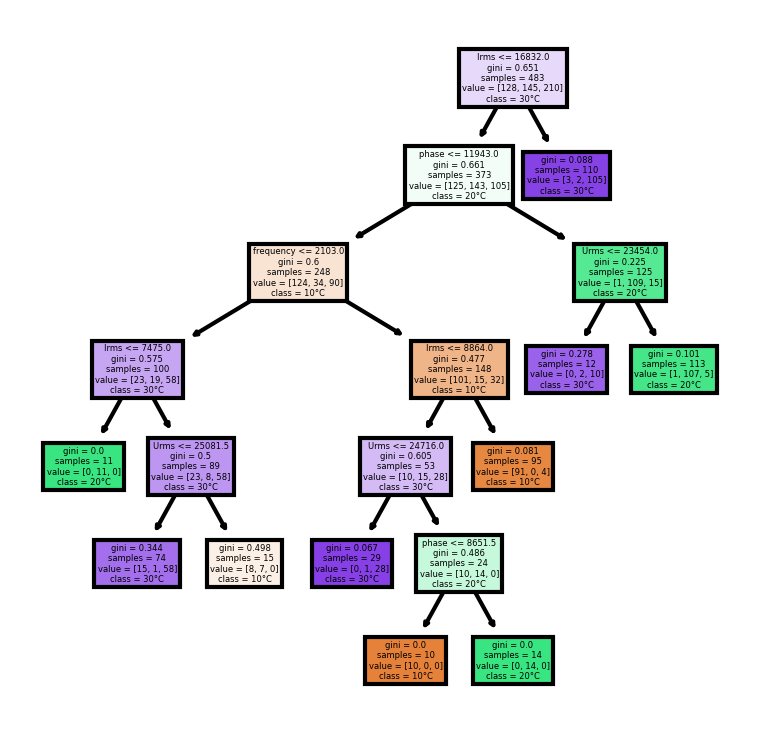

In [126]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
tree.plot_tree(classifier_concentration,
               feature_names = features_dt, 
               class_names=categories_str,
               filled = True);
plt.show()

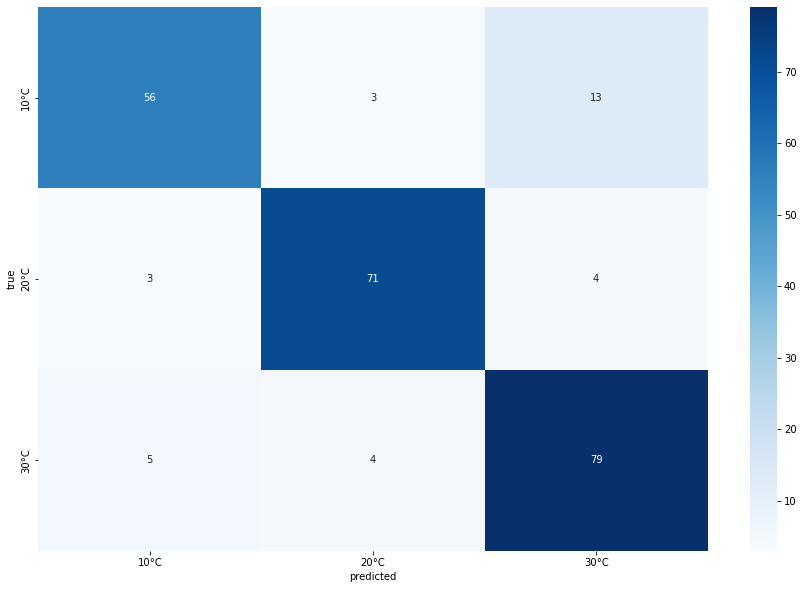

In [127]:
cf_matrix = confusion_matrix(y_test, y_predicted, labels= categories_str )
plt.subplots(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True, xticklabels=categories_str, yticklabels=categories_str, fmt='', cmap='Blues')
plt.xlabel("predicted") 
plt.ylabel("true")
plt.show()

### SVM

#### Classification

In [128]:
from sklearn import svm, datasets
from sklearn.svm import SVC
import sklearn.model_selection as model_selection
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [129]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(x1_dt, y_1_cat, test_size=0.20)


In [130]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred_lin = svclassifier.predict(X_test)
print("SVM - linear:")
print(accuracy_score(y_test,y_pred_lin))

svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred_rbf = svclassifier.predict(X_test)
print("SVM - rbf:")
print(accuracy_score(y_test,y_pred_rbf))

SVM - linear:
0.7862068965517242
SVM - rbf:
0.8068965517241379


### Regression

#### OLS

In [131]:
from sklearn import linear_model
# fit a regression model to the data: ols .. ordinary least square model

model = smf.ols(formula = "temperature ~ Urms + Irms + phase", data = df).fit()

In [132]:
#info about model
model.summary()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.208    
Dependent Variable: temperature      AIC:                6036.8725
Date:               2022-01-19 14:44 BIC:                6056.0732
No. Observations:   898              Log-Likelihood:     -3014.4  
Df Model:           3                F-statistic:        79.42    
Df Residuals:       894              Prob (F-statistic): 1.49e-45 
R-squared:          0.210            Scale:              48.437   
-------------------------------------------------------------------
              Coef.    Std.Err.     t     P>|t|    [0.025   0.975] 
-------------------------------------------------------------------
Intercept    100.2534   20.7833   4.8238  0.0000  59.4637  141.0432
Urms          -0.0033    0.0008  -4.3845  0.0000  -0.0048   -0.0018
Irms           0.0006    0.0001   8.0828  0.0000   0.0004    0.0007
phase         -0.0005    0.0002  -2.3300  0.0200  -0.0009   -0.0001
------------------------------------------------------------------
Omnibus:              56.325       Durbin-Watson:          0.047  
Prob(Omnibus):        0.000        Jarque-Bera (JB):       22.122 
Skew:                 0.105        Prob(JB):               0.000  
Kurtosis:             2.260        Condition No.:          2671707
==================================================================
* The condition number is large (3e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

#### SVM

In [133]:
features_SVM = ['Urms', 'Irms', 'phase', 'frequency']
target_SVM = ['temperature']
X = df[features_SVM].copy()
X

,Urms,Irms,phase,frequency
0,24998.0,7365.0,9520.0,2007
1,25003.0,7370.0,9523.0,2007
2,25003.0,7373.0,9529.0,2007
3,25004.0,7373.0,9531.0,2007
4,25004.0,7375.0,9533.0,2007
...,...,...,...,...
893,24604.0,5539.0,13173.0,2207
894,24601.0,5198.0,13047.0,2207
895,24668.0,4659.0,10691.0,2207
896,24689.0,4826.0,10691.0,2207


In [134]:
y = df[target_SVM].copy()
y

,temperature
0,19.91
1,19.90
2,19.89
3,19.89
4,19.85
...,...
893,29.97
894,29.98
895,29.97
896,29.96


In [135]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.40, random_state=42)

In [136]:
from sklearn.svm import SVR
# most important SVR parameter is Kernel type. It can be #linear,polynomial or gaussian SVR. We have a non-linear condition #so we can select polynomial or gaussian but here we select RBF(a #gaussian type) kernel.
regressor = SVR(kernel='poly')
regressor.fit(X_train,y_train)

SVR(kernel='poly')

In [137]:
y_pred = regressor.predict(X_test)
y_pred

array([ 0.35647806,  0.96941003,  0.78740774,  0.81811896, -0.34202031,
        0.16604096, -0.24241863,  0.02293025, -0.20256709, -0.01551444,
       -0.04093635, -0.38099564,  0.36646124, -0.39420324, -0.22117042,
       -0.22259208,  0.08406363,  1.17080608,  1.25094991, -0.33346279,
        0.1442125 ,  0.06738178, -0.39474072, -0.04164749,  0.07449944,
        0.1141777 , -0.44124707,  0.84926815, -0.26128295,  0.51724984,
        1.02935312, -1.26329448, -1.3578096 ,  0.06508568, -0.29759507,
        0.29030144, -0.25082019, -0.33280474, -0.44376037, -0.38010686,
       -0.33436312, -0.04966084,  1.35824373, -0.38172572, -0.79566166,
       -0.47957902, -0.17087172,  0.6812166 ,  0.14994267,  0.50228554,
       -0.24813984,  0.13167114, -0.39220894,  0.20053975, -0.20964413,
       -0.98360489, -1.02859631,  1.08698739,  0.12270453, -0.36656001,
       -0.13710979,  1.28605152,  1.18586247, -0.41790046, -0.38170941,
       -0.47443077, -1.10763095, -0.35448572, -0.23864826, -0.37

In [138]:
from sklearn.metrics import r2_score,mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.7122950828463448

#### PLSR